In [ ]:
!pip install adjustText
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter

# READ CUMULATIVE TABLE
covid_cumulative = pd.read_excel("covid_a_master_cumulative_table.xlsx")
covid_cumulative

,Unnamed: 0,DateRep,Country,Cases,Deaths,Date,Countries,Population,Continent
0,0,2019-12-31,Afghanistan,0,0,2019-12-31,Afghanistan,38041757.0,Asia
1,1,2019-12-31,Algeria,0,0,2019-12-31,Algeria,43053054.0,Africa
2,2,2019-12-31,Armenia,0,0,2019-12-31,Armenia,2957728.0,Europe
3,3,2019-12-31,Australia,0,0,2019-12-31,Australia,25203200.0,Oceania
4,4,2019-12-31,Austria,0,0,2019-12-31,Austria,8858775.0,Europe
...,...,...,...,...,...,...,...,...,...
38906,38906,2020-08-27,Vietnam,1034,30,2020-08-27,Vietnam,96462108.0,Asia
38907,38907,2020-08-27,Western_Sahara,766,1,2020-08-27,Western_Sahara,582458.0,Africa
38908,38908,2020-08-27,Yemen,1930,560,2020-08-27,Yemen,29161922.0,Asia
38909,38909,2020-08-27,Zambia,11376,282,2020-08-27,Zambia,17861034.0,Africa


In [ ]:
# This part is necessary instead of simply ['Date'].max() because some countries do not report on certain days (e.g. Spain on Sundays) -- FIXED BUG
last_day_per_country = covid_cumulative.groupby(['Countries'])['Date'].max() # type(last_day_per_country) is pandas.Series
last_day_per_country = last_day_per_country.to_frame() # We convert it to pandas.DataFrame
last_day_per_country.reset_index(inplace=True) # And reset the index so that we can further join on 'Countries'
last_day_per_country

,Countries,Date
0,Afghanistan,2020-08-27
1,Albania,2020-08-27
2,Algeria,2020-08-27
3,Andorra,2020-08-27
4,Angola,2020-08-27
...,...,...
205,Vietnam,2020-08-27
206,Western_Sahara,2020-08-27
207,Yemen,2020-08-27
208,Zambia,2020-08-27


In [ ]:
# N: HOW MANY TOP COUNTRIES YOU WANT TO PICK IN TERMS OF # OF DEATHS
N = 20
last_day = pd.merge(covid_cumulative, last_day_per_country, how='inner', left_on = ['Countries', 'Date'], right_on = ['Countries', 'Date'])
last_day = last_day.sort_values('Deaths', ascending=False)
last_day
top_countries = last_day[:N]['Countries'].tolist()
top_countries

['USA',
 'Brazil',
 'Mexico',
 'India',
 'UK',
 'Italy',
 'France',
 'Spain',
 'Peru',
 'Iran',
 'Colombia',
 'Russia',
 'S.Africa',
 'Chile',
 'Belgium',
 'Germany',
 'Canada',
 'Argentina',
 'Indonesia',
 'Iraq']

In [ ]:
# K: HOW MANY DEATHS YOU CONSIDER THE DAY 0
K = 10
covid_top_countries = covid_cumulative[covid_cumulative.Countries.isin(top_countries)]
covid_top_countries = covid_top_countries[covid_top_countries['Deaths'] > K]
covid_top_countries

,Unnamed: 0,DateRep,Country,Cases,Deaths,Date,Countries,Population,Continent
3781,3781,2020-02-25,Iran,61,12,2020-02-25,Iran,82913893.0,Asia
3848,3848,2020-02-26,Iran,95,15,2020-02-26,Iran,82913893.0,Asia
3852,3852,2020-02-26,Italy,322,11,2020-02-26,Italy,60359546.0,Europe
3915,3915,2020-02-27,Iran,139,19,2020-02-27,Iran,82913893.0,Asia
3919,3919,2020-02-27,Italy,400,12,2020-02-27,Italy,60359546.0,Europe
...,...,...,...,...,...,...,...,...,...
38854,38854,2020-08-27,Peru,613378,28124,2020-08-27,Peru,32510462.0,America
38861,38861,2020-08-27,Russia,970865,16683,2020-08-27,Russia,145872260.0,Europe
38863,38863,2020-08-27,S.Africa,615701,13502,2020-08-27,S.Africa,58558267.0,Africa
38897,38897,2020-08-27,UK,328846,41465,2020-08-27,UK,66647112.0,Europe


In [ ]:
# FIND THE DATE THAT THE FIRST K DEATHS WERE IDENTIFIED
day_0_for_every_country = covid_top_countries.groupby(['Countries'])['Date'].min()
day_0_for_every_country

Countries
Argentina   2020-03-27
Belgium     2020-03-15
Brazil      2020-03-21
Canada      2020-03-21
Chile       2020-04-01
Colombia    2020-03-31
France      2020-03-09
Germany     2020-03-16
India       2020-03-26
Indonesia   2020-03-20
Iran        2020-02-25
Iraq        2020-03-18
Italy       2020-02-26
Mexico      2020-03-28
Peru        2020-03-28
Russia      2020-04-01
S.Africa    2020-04-06
Spain       2020-03-10
UK          2020-03-15
USA         2020-03-05
Name: Date, dtype: datetime64[ns]

In [ ]:
# MERGE THE TWO TO GET THE DAY_0 IN THE df, AND CALCULATE THE DAYS_FROM_0
covid_top_countries = covid_top_countries.merge(day_0_for_every_country, how='inner', on='Countries')
covid_top_countries.rename(columns = {'Date_y': 'Day_0'}, inplace = True)
covid_top_countries['Days_from_0'] = (covid_top_countries['Date_x'] - covid_top_countries['Day_0']).dt.days
covid_top_countries

,Unnamed: 0,DateRep,Country,Cases,Deaths,Date_x,Countries,Population,Continent,Day_0,Days_from_0
0,3781,2020-02-25,Iran,61,12,2020-02-25,Iran,82913893.0,Asia,2020-02-25,0
1,3848,2020-02-26,Iran,95,15,2020-02-26,Iran,82913893.0,Asia,2020-02-25,1
2,3915,2020-02-27,Iran,139,19,2020-02-27,Iran,82913893.0,Asia,2020-02-25,2
3,3982,2020-02-28,Iran,245,26,2020-02-28,Iran,82913893.0,Asia,2020-02-25,3
4,4049,2020-02-29,Iran,388,34,2020-02-29,Iran,82913893.0,Asia,2020-02-25,4
...,...,...,...,...,...,...,...,...,...,...,...
3230,38027,2020-08-23,S.Africa,607045,12987,2020-08-23,S.Africa,58558267.0,Africa,2020-04-06,139
3231,38236,2020-08-24,S.Africa,609773,13059,2020-08-24,S.Africa,58558267.0,Africa,2020-04-06,140
3232,38445,2020-08-25,S.Africa,611450,13159,2020-08-25,S.Africa,58558267.0,Africa,2020-04-06,141
3233,38654,2020-08-26,S.Africa,613017,13308,2020-08-26,S.Africa,58558267.0,Africa,2020-04-06,142


In [ ]:
#For graph labelling
max_deaths = covid_top_countries.groupby(by=['Countries']).max()
max_deaths.drop('Unnamed: 0', axis = 1, inplace = True)
max_deaths.sort_values(by=['Deaths'],ascending=False,inplace=True)
max_deaths

,DateRep,Country,Cases,Deaths,Date_x,Population,Continent,Day_0,Days_from_0
Countries,,,,,,,,,
USA,2020-08-27,USA,5821876,179714,2020-08-27,3.290649e+08,America,2020-03-05,175
Brazil,2020-08-27,Brazil,3717156,117665,2020-08-27,2.110495e+08,America,2020-03-21,159
Mexico,2020-08-27,Mexico,573888,62076,2020-08-27,1.275755e+08,America,2020-03-28,152
India,2020-08-27,India,3310234,60472,2020-08-27,1.366418e+09,Asia,2020-03-26,154
UK,2020-08-27,UK,328846,41465,2020-08-27,6.664711e+07,Europe,2020-03-15,165
Italy,2020-08-27,Italy,262540,35458,2020-08-27,6.035955e+07,Europe,2020-02-26,183
France,2020-08-27,France,253587,30544,2020-08-27,6.701288e+07,Europe,2020-03-09,171
Spain,2020-08-26,Spain,419849,28971,2020-08-26,4.693706e+07,Europe,2020-03-10,169
Peru,2020-08-27,Peru,613378,28124,2020-08-27,3.251046e+07,America,2020-03-28,152


In [ ]:
# FUNCTION THAT GIVES YOU THE DOUBLING SLOPE OF 1, 2, 3, 7 DAYS
x1 = np.array([0, 15])
x2 = np.array([0, 30])
x3 = np.array([0, 45])
x7 = np.array([0, 105])

y_1 = np.array([K, K*2**(x1[1])])
y_2 = np.array([K, K*2**(x2[1]/2)])
y_3 = np.array([K, K*2**(x3[1]/3)])
y_7 = np.array([K, K*2**(x7[1]/7)])

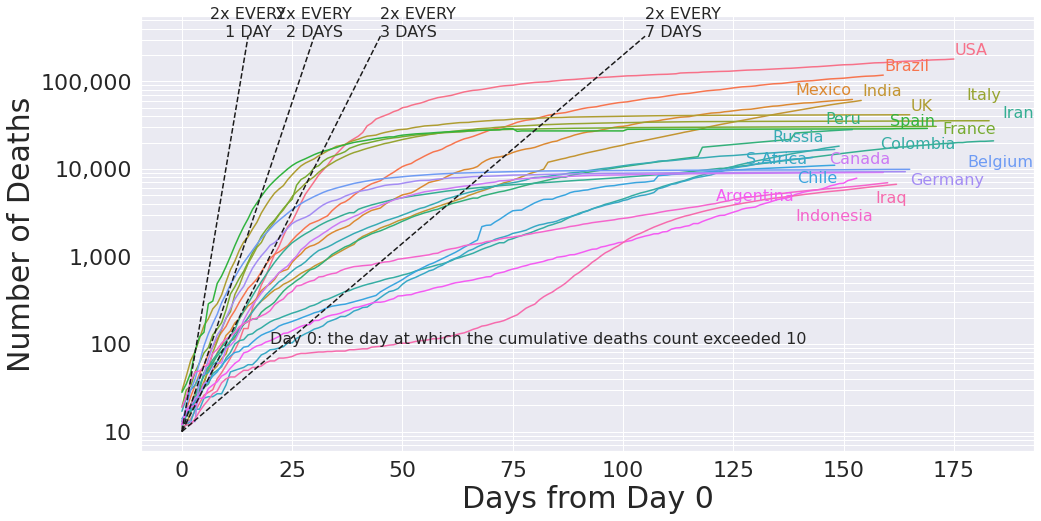

In [ ]:
sns.set(rc={'figure.figsize':(16,8)}, font_scale = 2)
style = dict(size=10, color='gray')

ax = sns.lineplot(x="Days_from_0", y="Deaths", hue="Countries", data=covid_top_countries, markers=True, hue_order=top_countries, legend=False)
ax.set_yscale('log')
plt.grid(True, which='both')
ax.plot(x1, y_1, 'k--')
ax.plot(x2, y_2, 'k--')
ax.plot(x3, y_3, 'k--')
ax.plot(x7, y_7, 'k--')
ax.set_xlabel("Days from Day 0",fontsize=30)
ax.set_ylabel("Number of Deaths",fontsize=30)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# plt.xlim([0, 150])
plt.text(20, 100, 'Day 0: the day at which the cumulative deaths count exceeded {:.0f}'.format(K), fontsize=16)
plt.text(x1.max(), y_1.max(), '2x EVERY\n1 DAY', ha = 'center', fontsize=16)
plt.text(x2.max(), y_2.max(), '2x EVERY\n2 DAYS', ha = 'center', fontsize=16)
plt.text(x3.max(), y_3.max(), '2x EVERY\n3 DAYS', ha = 'left', fontsize=16)
plt.text(x7.max(), y_7.max(), '2x EVERY\n7 DAYS', ha = 'left', fontsize=16)
texts = [plt.text(max_deaths.loc[str(country)]['Days_from_0'], max_deaths.loc[str(country)]['Deaths'], str(country), fontsize=16, color=ax.get_lines()[top_countries.index(country)].get_c(), ha = 'center', va = 'center') for country in top_countries]
adjust_text(texts)

plt.savefig('Fig_1_1_Desai_Ashutosh.png')

In [ ]:
# back_calc IS THE BACK WINDOW THAT IS USED TO CALCULATE THE SLOPE
back_calc = 7
slope_df = pd.DataFrame(columns=['Countries', 'Days_from_0', 'Slope', 'R2', 'P_value'])

for country in top_countries:
    one_country_data = covid_top_countries[covid_top_countries['Countries'] == str(country)].reset_index(drop=True)
#     one_country_data['log_cases'] = np.log10(one_country_data['Cases'])
    for i in np.arange(back_calc, len(one_country_data)+1):
        x = one_country_data.loc[i-back_calc: i, 'Days_from_0'] # That is the 'Days_from_0'
        y = one_country_data.loc[i-back_calc: i, 'Deaths'] # 
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        one_country_data.loc[i-1, 'Slope'] = slope
        one_country_data.loc[i-1, 'R2'] = r_value * r_value
        one_country_data.loc[i-1, 'P_value'] = p_value
        one_country = one_country_data[['Countries', 'Days_from_0', 'Slope', 'R2', 'P_value']]
    
    slope_df = slope_df.append(one_country, ignore_index=False)
    
slope_df.head(15)

,Countries,Days_from_0,Slope,R2,P_value
0,USA,0,NaN,NaN,NaN
1,USA,1,NaN,NaN,NaN
2,USA,2,NaN,NaN,NaN
3,USA,3,NaN,NaN,NaN
4,USA,4,NaN,NaN,NaN
5,USA,5,NaN,NaN,NaN
6,USA,6,3.011905,0.974751,0.000005
7,USA,7,3.738095,0.958956,0.000022
8,USA,8,4.464286,0.952415,0.000034
9,USA,9,5.404762,0.941221,0.000065


In [ ]:
slope_df.set_index('Countries', drop=False, inplace=True)
slope_df.to_excel('covid_c_slope_daily.xlsx')

In [ ]:
slope_df.index.name = None
max_slope = slope_df.groupby(by=['Countries']).max()
max_slope = max_slope.sort_values('Slope', ascending=False)
max_slope['Countries'] = max_slope.index

data_1_5 = slope_df[slope_df.Countries.isin(max_slope[:5]['Countries'].tolist())]
countries_1_5 = max_slope[:5]['Countries'].tolist()
data_6_10 = slope_df[slope_df.Countries.isin(max_slope[5:10]['Countries'].tolist())]
countries_6_10 = max_slope[5:10]['Countries'].tolist()
data_11_15 = slope_df[slope_df.Countries.isin(max_slope[10:15]['Countries'].tolist())]
countries_11_15 = max_slope[10:15]['Countries'].tolist()
data_16_20 = slope_df[slope_df.Countries.isin(max_slope[15:20]['Countries'].tolist())]
countries_16_20 = max_slope[15:20]['Countries'].tolist()
max_slope

,Days_from_0,Slope,R2,P_value,Countries
Countries,,,,,
USA,175,2876.345238,0.998196,0.001091,USA
Brazil,159,1152.630952,0.997301,0.000060,Brazil
France,171,1010.666667,0.998144,0.019353,France
UK,165,977.142857,0.996646,0.000400,UK
India,154,971.190476,0.999857,0.000778,India
Peru,152,922.119048,0.999988,0.030433,Peru
Spain,169,872.214286,0.999424,1.000000,Spain
Italy,183,821.571429,0.999744,0.045427,Italy
Mexico,152,802.785714,0.996012,0.000237,Mexico


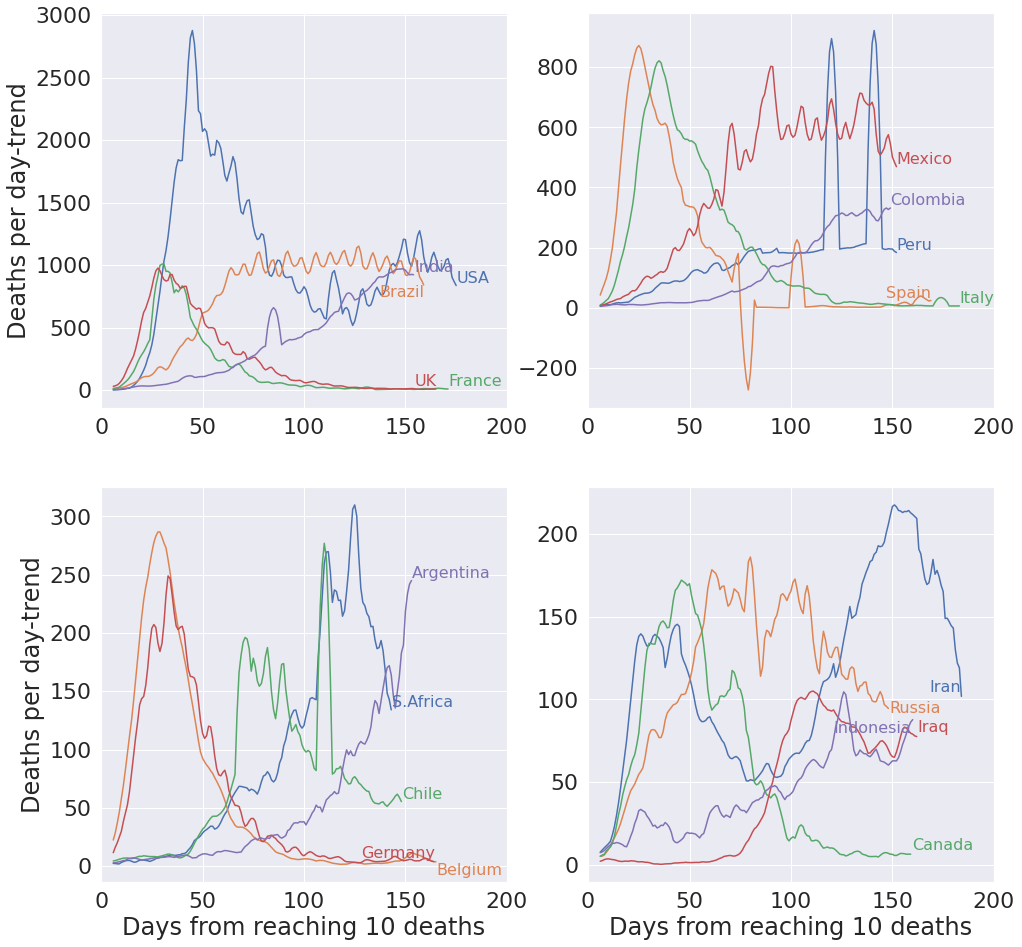

In [ ]:
sns.set(rc={'figure.figsize':(16,16)}, font_scale = 2)
fig, axes = plt.subplots(2, 2)

sns.lineplot(x="Days_from_0", y="Slope", hue="Countries", data=data_1_5, markers=True, hue_order=countries_1_5, legend=False, ax=axes[0, 0])
texts = [axes[0, 0].text(max_deaths.loc[str(country)]['Days_from_0'], slope_df.loc[str(country)]['Slope'].iloc[-1], str(country), fontsize=16, color=axes[0, 0].get_lines()[countries_1_5.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_1_5]
adjust_text(texts)
axes[0, 0].set_ylabel("Deaths per day-trend",fontsize=24)

sns.lineplot(x="Days_from_0", y="Slope", hue="Countries", data=data_6_10, markers=True, hue_order=countries_6_10, legend=False, ax=axes[0, 1])
texts = [axes[0, 1].text(max_deaths.loc[str(country)]['Days_from_0'], slope_df.loc[str(country)]['Slope'].iloc[-1], str(country), fontsize=16, color=axes[0, 1].get_lines()[countries_6_10.index(country)].get_c(), ha = 'left', va = 'top') for country in countries_6_10]
adjust_text(texts)

sns.lineplot(x="Days_from_0", y="Slope", hue="Countries", data=data_11_15, markers=True, hue_order=countries_11_15, legend=False, ax=axes[1, 0])
texts = [axes[1, 0].text(max_deaths.loc[str(country)]['Days_from_0'], slope_df.loc[str(country)]['Slope'].iloc[-1], str(country), fontsize=16, color=axes[1, 0].get_lines()[countries_11_15.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_11_15]
adjust_text(texts)
axes[1, 0].set_ylabel("Deaths per day-trend",fontsize=24)
axes[1, 0].set_xlabel("Days from reaching 10 deaths",fontsize=24)

sns.lineplot(x="Days_from_0", y="Slope", hue="Countries", data=data_16_20, markers=True, hue_order=countries_16_20, legend=False, ax=axes[1, 1])
texts = [axes[1, 1].text(max_deaths.loc[str(country)]['Days_from_0'], slope_df.loc[str(country)]['Slope'].iloc[-1], str(country), fontsize=16, color=axes[1, 1].get_lines()[countries_16_20.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_16_20]
adjust_text(texts)
axes[1, 1].set_xlabel("Days from reaching 10 deaths",fontsize=24)

axes[0, 1].set_ylabel("",fontsize=24)
axes[1, 1].set_ylabel("",fontsize=24)
axes[0, 0].set_xlabel("",fontsize=24)
axes[0, 1].set_xlabel("",fontsize=24)
axes[0, 1].set_xlim([0, 200])
axes[1, 1].set_xlim([0, 200])
axes[0, 0].set_xlim([0, 200])
axes[1, 0].set_xlim([0, 200])
# axes[0, 0].set_yscale('log')
# axes[0, 1].set_yscale('log')
# axes[1, 0].set_yscale('log')
# axes[1, 1].set_yscale('log')

plt.savefig('Fig_1_2_Desai_Ashutosh.png')

In [ ]:
death_rate = pd.read_excel('Death_rate_crude_per_1000_people.xls',sheet_name='Data',header=3,index_col=0)
death_rate.drop(columns=['Country Code','Indicator Name','Indicator Code'],inplace=True)
death_rate = death_rate.ffill(axis=1).iloc[:,-1]
death_rate = death_rate.to_frame(name='Death rate per 1000')
death_rate['Countries'] = death_rate.index
death_rate.replace('United States','USA',inplace=True)
death_rate.replace('United Kingdom','UK',inplace=True)
death_rate.replace('Korea, Rep.','S.Korea',inplace=True)
death_rate.replace('Iran, Islamic Rep.','Iran',inplace=True)
death_rate.replace('Saudi Arabia','S.Arabia',inplace=True)
death_rate.replace('South Africa','S.Africa',inplace=True)
death_rate = death_rate[death_rate.Countries.isin(top_countries)]
death_rate

,Death rate per 1000,Countries
Country Name,,
Argentina,7.616,Argentina
Belgium,9.600,Belgium
Brazil,6.378,Brazil
Canada,7.500,Canada
Chile,6.076,Chile
Colombia,5.503,Colombia
Germany,11.300,Germany
Spain,9.000,Spain
France,9.000,France


In [ ]:
death_rate = death_rate.merge(covid_top_countries,how='left',on='Countries')
death_rate

,Death rate per 1000,Countries,Unnamed: 0,DateRep,Country,Cases,Deaths,Date_x,Population,Continent,Day_0,Days_from_0
0,7.616,Argentina,6968,2020-03-27,Argentina,589,12,2020-03-27,44780675.0,America,2020-03-27,0
1,7.616,Argentina,7162,2020-03-28,Argentina,690,17,2020-03-28,44780675.0,America,2020-03-27,1
2,7.616,Argentina,7357,2020-03-29,Argentina,745,19,2020-03-29,44780675.0,America,2020-03-27,2
3,7.616,Argentina,7552,2020-03-30,Argentina,820,20,2020-03-30,44780675.0,America,2020-03-27,3
4,7.616,Argentina,7747,2020-03-31,Argentina,966,24,2020-03-31,44780675.0,America,2020-03-27,4
...,...,...,...,...,...,...,...,...,...,...,...,...
3230,9.498,S.Africa,38027,2020-08-23,S.Africa,607045,12987,2020-08-23,58558267.0,Africa,2020-04-06,139
3231,9.498,S.Africa,38236,2020-08-24,S.Africa,609773,13059,2020-08-24,58558267.0,Africa,2020-04-06,140
3232,9.498,S.Africa,38445,2020-08-25,S.Africa,611450,13159,2020-08-25,58558267.0,Africa,2020-04-06,141
3233,9.498,S.Africa,38654,2020-08-26,S.Africa,613017,13308,2020-08-26,58558267.0,Africa,2020-04-06,142


In [ ]:
death_rate['Typical_deaths_per_day'] = death_rate['Death rate per 1000'] * death_rate['Population']/1000/365
death_rate['Typical_cumulative_deaths'] = (death_rate['Days_from_0'] + 1)*death_rate['Typical_deaths_per_day']
death_rate['Excess_death_rate'] = death_rate['Deaths'] / death_rate['Typical_cumulative_deaths'] * 100
death_rate

,Death rate per 1000,Countries,Unnamed: 0,DateRep,Country,Cases,Deaths,Date_x,Population,Continent,Day_0,Days_from_0,Typical_deaths_per_day,Typical_cumulative_deaths,Excess_death_rate
0,7.616,Argentina,6968,2020-03-27,Argentina,589,12,2020-03-27,44780675.0,America,2020-03-27,0,934.382523,934.382523,1.284271
1,7.616,Argentina,7162,2020-03-28,Argentina,690,17,2020-03-28,44780675.0,America,2020-03-27,1,934.382523,1868.765045,0.909692
2,7.616,Argentina,7357,2020-03-29,Argentina,745,19,2020-03-29,44780675.0,America,2020-03-27,2,934.382523,2803.147568,0.677809
3,7.616,Argentina,7552,2020-03-30,Argentina,820,20,2020-03-30,44780675.0,America,2020-03-27,3,934.382523,3737.530091,0.535113
4,7.616,Argentina,7747,2020-03-31,Argentina,966,24,2020-03-31,44780675.0,America,2020-03-27,4,934.382523,4671.912614,0.513708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,9.498,S.Africa,38027,2020-08-23,S.Africa,607045,12987,2020-08-23,58558267.0,Africa,2020-04-06,139,1523.798411,213331.777521,6.087701
3231,9.498,S.Africa,38236,2020-08-24,S.Africa,609773,13059,2020-08-24,58558267.0,Africa,2020-04-06,140,1523.798411,214855.575932,6.078036
3232,9.498,S.Africa,38445,2020-08-25,S.Africa,611450,13159,2020-08-25,58558267.0,Africa,2020-04-06,141,1523.798411,216379.374343,6.081448
3233,9.498,S.Africa,38654,2020-08-26,S.Africa,613017,13308,2020-08-26,58558267.0,Africa,2020-04-06,142,1523.798411,217903.172754,6.107300


In [ ]:
#Code for line text
idx = death_rate.groupby(['Countries'])['Days_from_0'].transform(max) == death_rate['Days_from_0']
new_data1 = death_rate[idx]
#new_data[new_data['Countries'] == 'Canada']['Excess_death_rate']

In [ ]:
max_excess_deaths = death_rate.groupby(['Countries']).max()
max_excess_deaths.sort_values('Excess_death_rate', ascending=False,inplace=True)

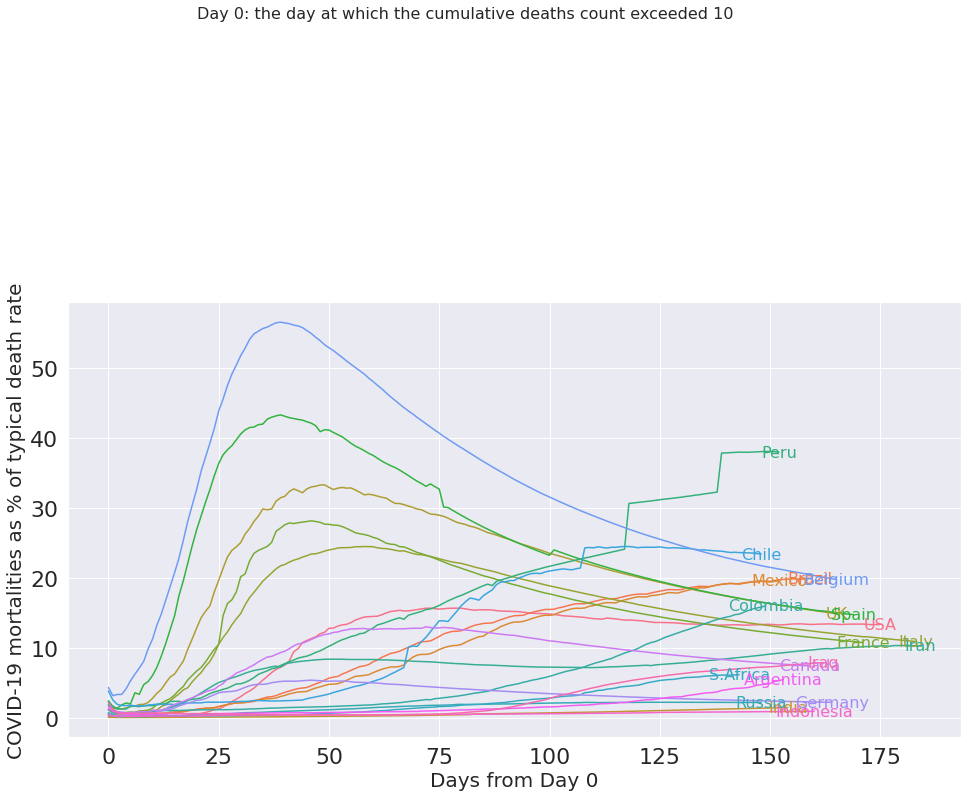

In [ ]:
sns.set(rc={'figure.figsize':(16,8)}, font_scale = 2)
style = dict(size=10, color='gray')

ax = sns.lineplot(x="Days_from_0", y="Excess_death_rate", hue="Countries", data=death_rate, markers=True, hue_order=top_countries, legend=False)
ax.set_yscale('linear')
plt.grid(True, which='both')
ax.set_xlabel("Days from Day 0",fontsize=20)
ax.set_ylabel("COVID-19 mortalities as % of typical death rate",fontsize=20)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.text(20, 100, 'Day 0: the day at which the cumulative deaths count exceeded {:.0f}'.format(K), fontsize=16)
texts = [plt.text(max_excess_deaths.loc[str(country)]['Days_from_0'], new_data1[new_data1['Countries'] == str(country)]['Excess_death_rate'], str(country), fontsize=16, color=ax.get_lines()[top_countries.index(country)].get_c(), ha = 'center', va = 'center') for country in top_countries]
#adjust_text(texts)

plt.savefig('Fig_1_3_Desai_Ashutosh.png')